In [1]:
import sys
import os
project_path = os.path.abspath("..")
sys.path.append(project_path)

In [2]:
from utilities.grover_state_preparation import *
from utilities.auxiliaries import *
from config import *
     

import numpy as np
from scipy.stats import beta, entropy, wasserstein_distance
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.visualization import circuit_drawer

In [3]:
idx_thetas_to_optimize = [0]

p_i_set = beta.pdf(np.linspace(a, b, 2**m), alpha_, beta_) 
p_i_set /= p_i_set.sum()
     
thetas_to_optimize = np.array(generate_parameters(len(idx_thetas_to_optimize), k=2))
thetas = get_grover_angles(p_i_set, m)


Initial thetas:
[np.float64(1.5707963267948968), np.float64(1.9749504449129769), np.float64(1.1666422086768165), np.float64(2.0783902543989505), np.float64(1.6414173070377212), np.float64(1.5001753465520722), np.float64(1.0632023991908435), np.float64(2.155226400136455), np.float64(1.707507988642507), np.float64(1.627766640873918), np.float64(1.5872749304419433), np.float64(1.5543177231478496), np.float64(1.5138260127158754), np.float64(1.4340846649472863), np.float64(0.9863662534533388), np.float64(2.2907377857393296), np.float64(1.736634806654874), np.float64(1.6576906464190724), np.float64(1.6247955793725783), np.float64(1.6060237381587685), np.float64(1.5932449013108987), np.float64(1.5833621025051126), np.float64(1.574849022792449), np.float64(1.5667436307973441), np.float64(1.5582305510846808), np.float64(1.5483477522788947), np.float64(1.5355689154310246), np.float64(1.5167970742172148), np.float64(1.4839020071707207), np.float64(1.4049578469349189), np.float64(0.85085486785046

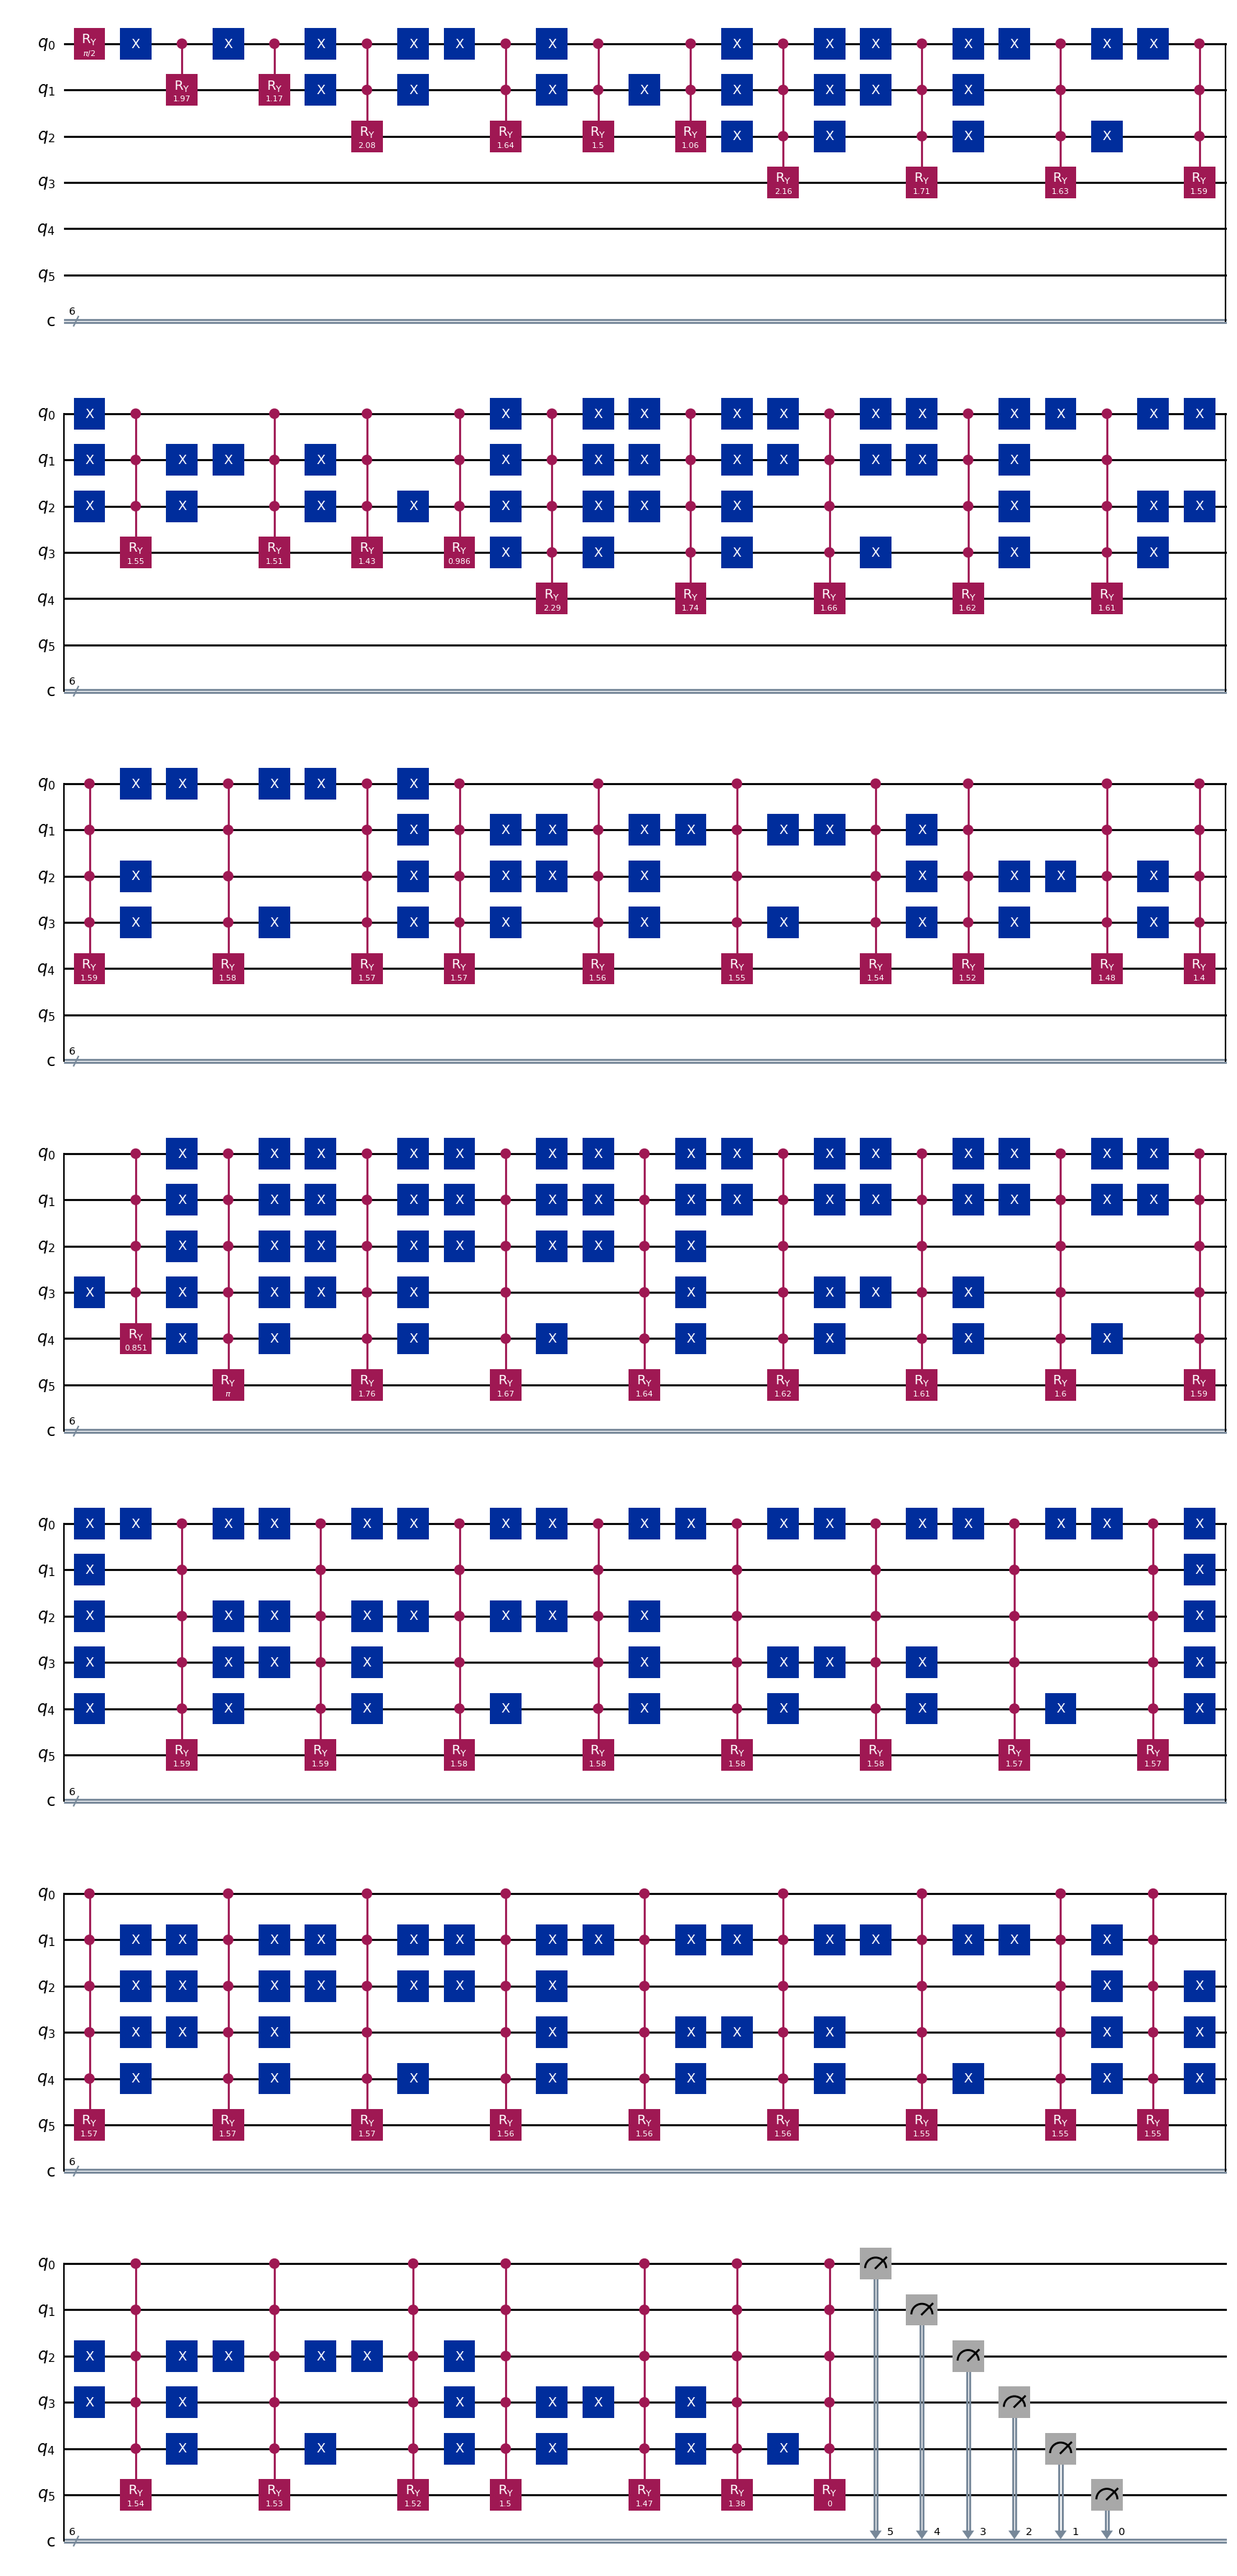

In [4]:
initial_qc = state_expansion(m, thetas)
print("\nInitial thetas:")
print(thetas)
print("\nStarting circuit:")
circuit_drawer(initial_qc, output='mpl')

In [5]:
loss = []
extra_angles = []
samples_all = []
loss_history = []
best_loss = float('inf')
best_thetas = None
best_distribution = None
for run in range(runs):
    result = minimize(objective_function, thetas_to_optimize,
                      args=(idx_thetas_to_optimize, thetas, p_i_set, shots),
                      method=optimizer_type, options={"disp": False, "maxiter": max_iterations})
    current_loss = result.fun
    thetas_to_optimize = result.x
    loss_history.append(current_loss)
    if current_loss < best_loss:
        best_loss = current_loss
        best_thetas = np.array(thetas.copy())
        best_thetas[idx_thetas_to_optimize] = thetas_to_optimize

In [6]:
#final_qc  = state_expansion(m, best_thetas)
#t_qc = transpile(final_qc , backend=backend)
#job = backend.run(t_qc, shots=shots)
#counts = job.result().get_counts(final_qc )
#samples = np.array([counts.get(state, 0) for state in all_states], dtype=float)
#samples /= samples.sum()
#emd = wasserstein_distance(samples, p_i_set)
#kl_div = entropy(samples, p_i_set)
#print(f"KL Divergence: {kl_div:.6f}")
#print(f"Earth Mover's Distance: {emd}")

In [7]:
final_qc  = state_expansion(m, best_thetas)
t_qc = transpile(final_qc , backend=backend)
job = backend.run(t_qc, shots=shots)
counts = job.result().get_counts(final_qc)

samples = np.array([counts.get(state, 0) for state in all_states], dtype=float)
samples /= samples.sum()


# common grid used for the bins -- computing distances
x = np.linspace(a, b, 2**m)

emd = wasserstein_distance(x, x, u_weights=samples, v_weights=p_i_set)  # Wasserstein (Earth Mover's Distance)


eps = 1e-12
kl_div = entropy(samples + eps, p_i_set + eps)                          # KL Divergence 

l2 = np.sum((samples - p_i_set)**2)

cdf_gen = np.cumsum(samples)
cdf_target = np.cumsum(p_i_set)
ks = np.max(np.abs(cdf_gen - cdf_target))                               # Kolmogorov–Smirnov


print(f"L2: {l2:.6e}")
print(f"KL Divergence: {kl_div:.6e}")
print(f"Earth Mover's Distance: {emd:.6e}")
print(f"KS distance: {ks:.6e}")


L2: 9.138016e-04
KL Divergence: 3.275912e-02
Earth Mover's Distance: 4.306490e-03
KS distance: 1.311984e-02


In [8]:
# debugging info
print(len(p_i_set))

64


In [9]:
# debugging info
print(len(samples))

64



Final thetas:
[1.55736661 1.97495044 1.16664221 2.07839025 1.64141731 1.50017535
 1.0632024  2.1552264  1.70750799 1.62776664 1.58727493 1.55431772
 1.51382601 1.43408466 0.98636625 2.29073779 1.73663481 1.65769065
 1.62479558 1.60602374 1.5932449  1.5833621  1.57484902 1.56674363
 1.55823055 1.54834775 1.53556892 1.51679707 1.48390201 1.40495785
 0.85085487 3.14159265 1.76404997 1.67363912 1.63896901 1.62049281
 1.60891808 1.60091181 1.59498076 1.59035429 1.58659285 1.58342582
 1.58067574 1.57821951 1.57596698 1.57384821 1.57180541 1.56978724
 1.56774444 1.56562567 1.56337314 1.56091691 1.55816683 1.5549998
 1.55123837 1.54661189 1.54068084 1.53267457 1.52109985 1.50262364
 1.46795354 1.37754268 0.        ]

Final circuit:


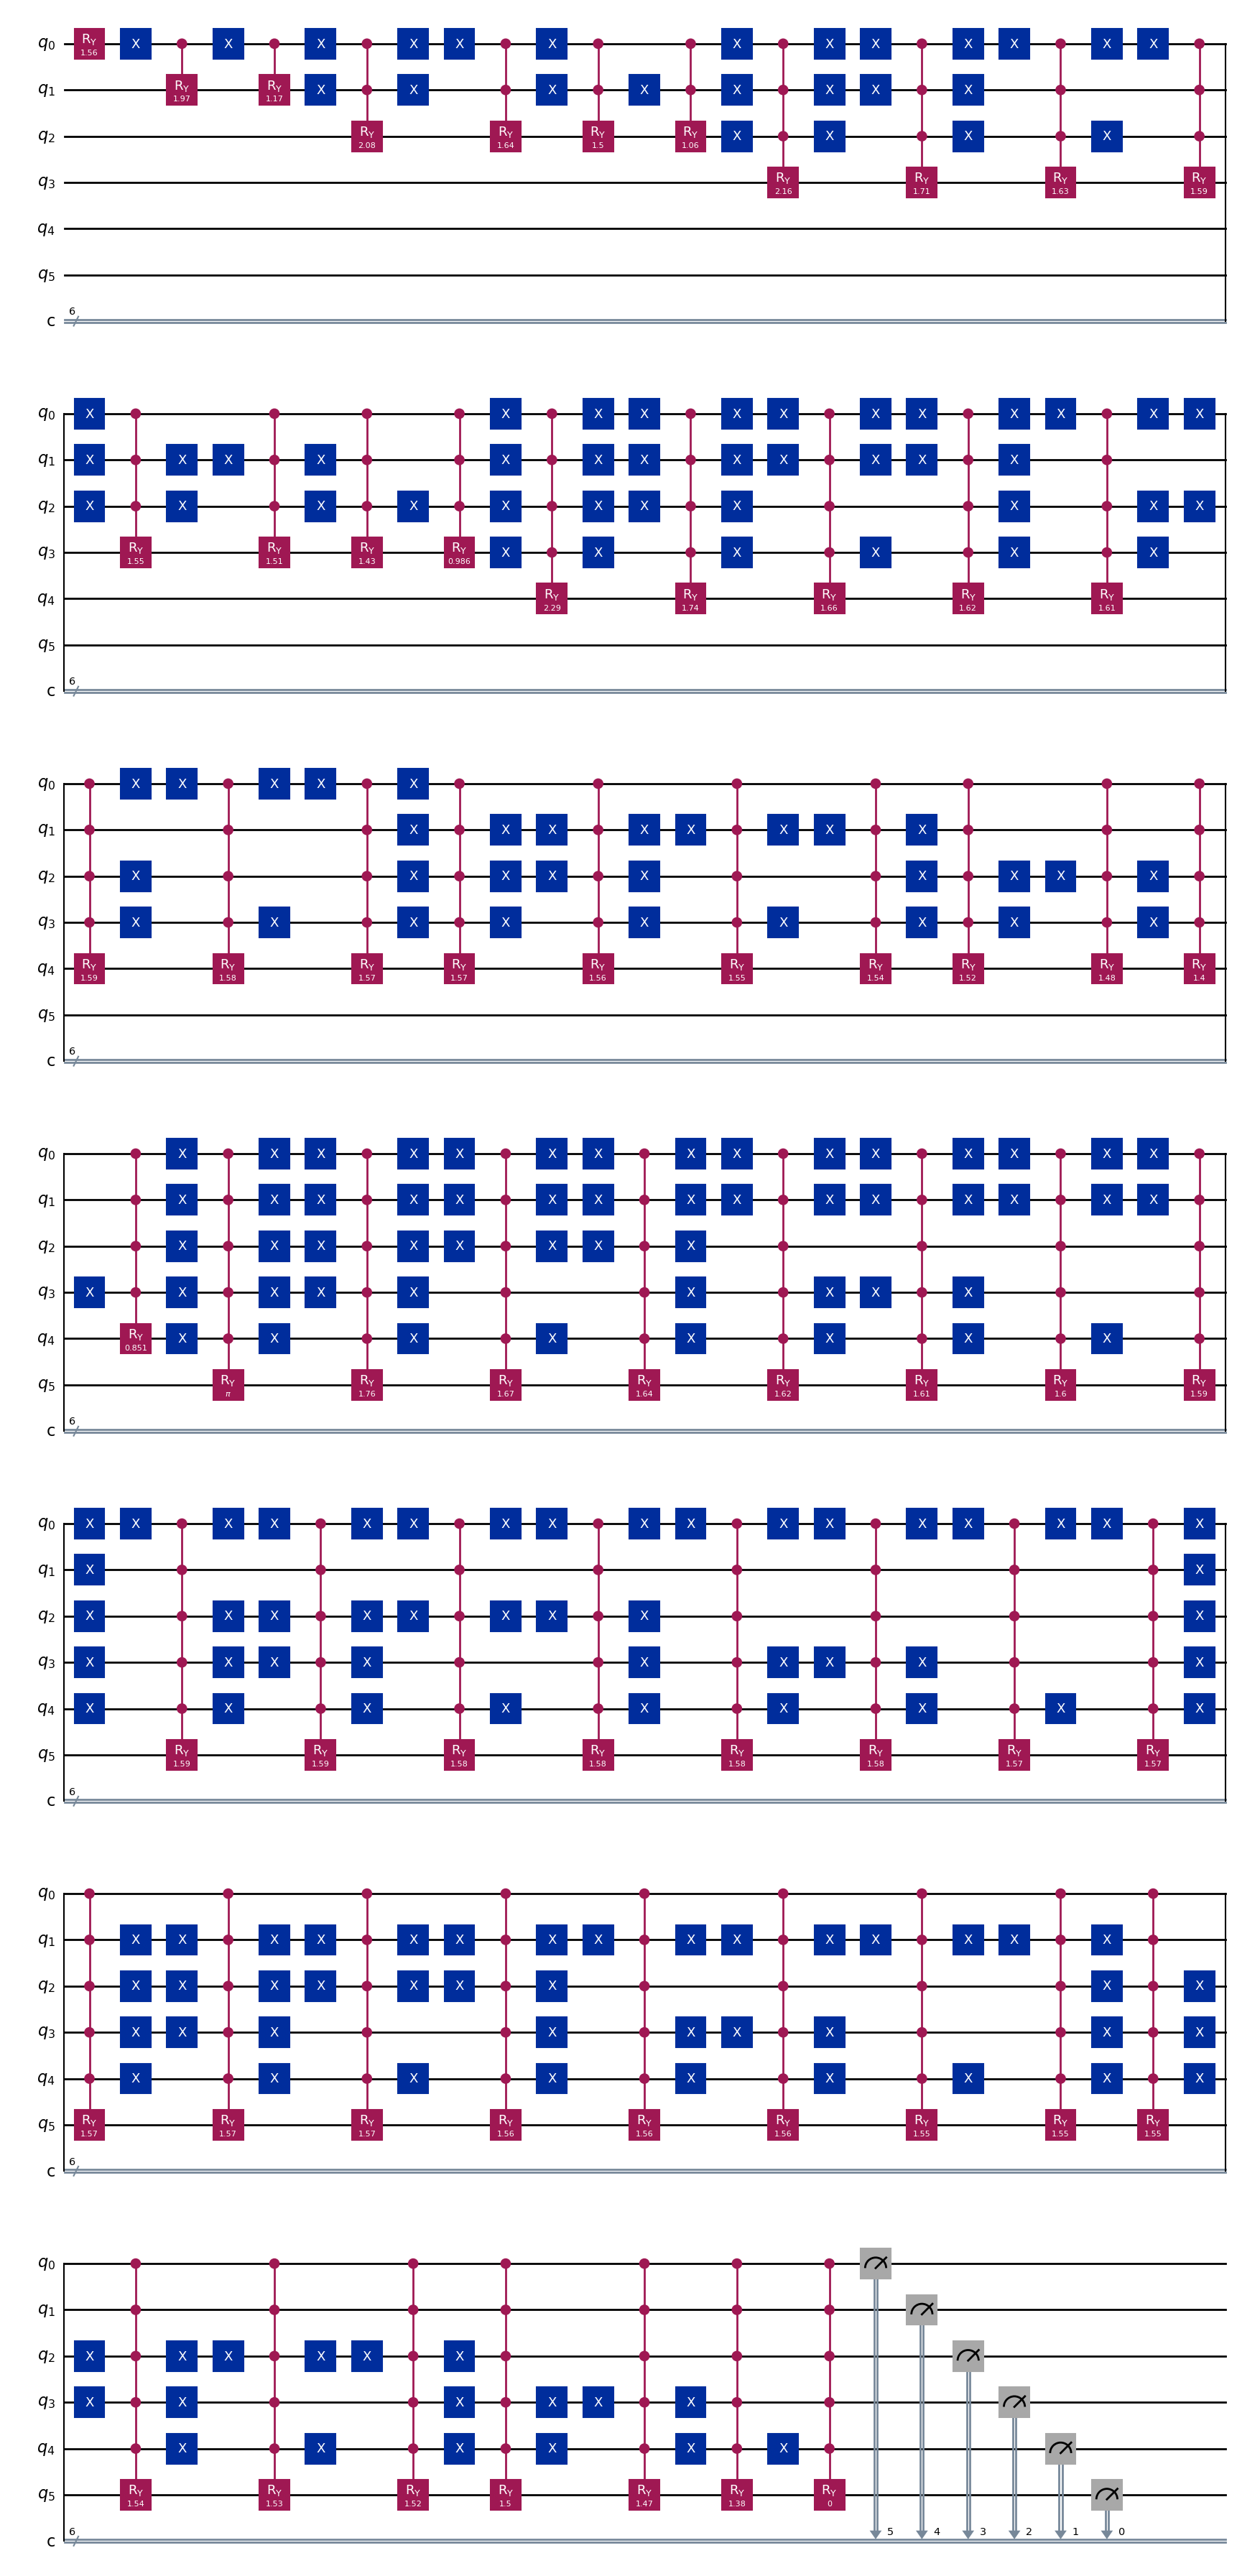

In [10]:
print("\nFinal thetas:")
print(best_thetas)
final_qc = state_expansion(m, best_thetas)
print("\nFinal circuit:")
circuit_drawer(final_qc, output='mpl')

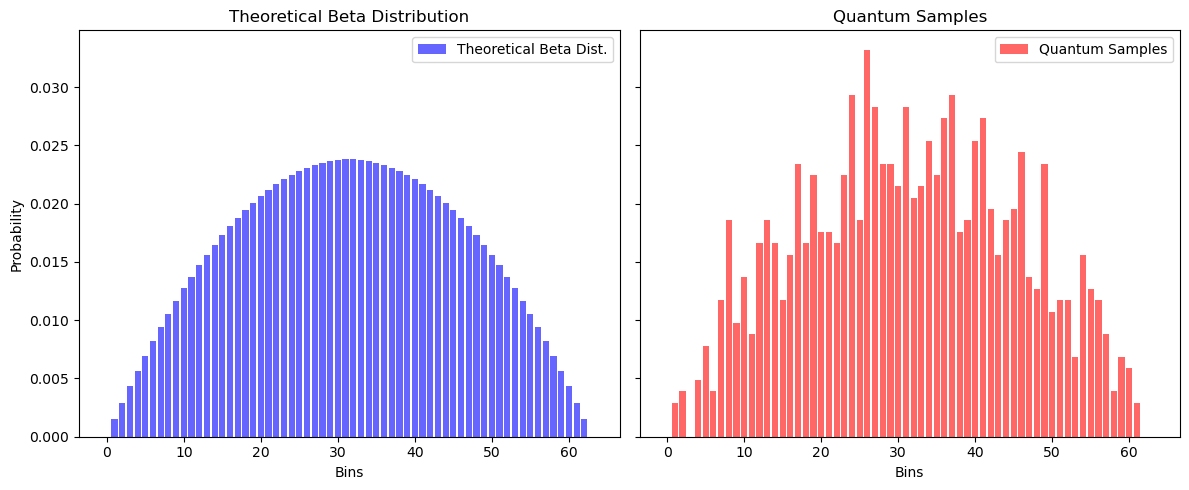

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')
axes[0].set_xlabel("Bins")
axes[0].set_ylabel("Probability")
axes[0].legend()
axes[0].set_title("Theoretical Beta Distribution")

axes[1].bar(range(len(samples)), samples, alpha=0.6, label='Quantum Samples', color='red')
axes[1].set_xlabel("Bins")
axes[1].legend()
axes[1].set_title("Quantum Samples")

plt.tight_layout()
plt.show()


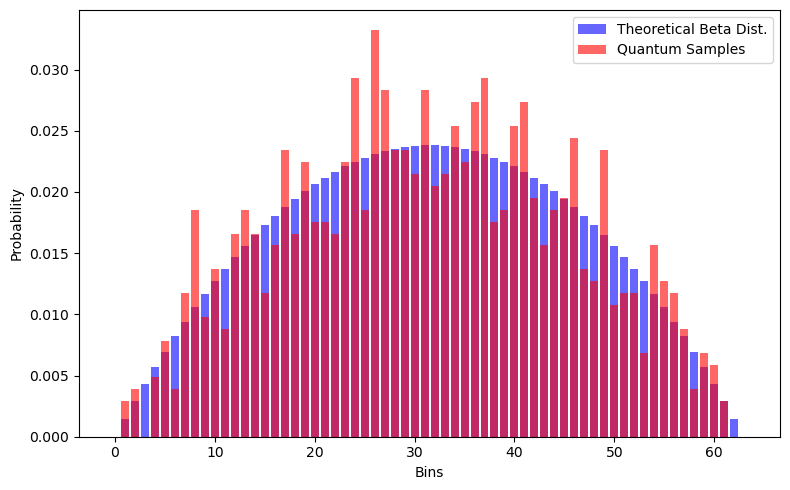

In [12]:

fig, ax = plt.subplots(figsize=(8, 5))

# Istogramma della distribuzione teorica
ax.bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')

# Istogramma dei campioni quantistici sovrapposto
ax.bar(range(len(samples)), samples, alpha=0.6, label='Quantum Samples', color='red')

# Etichette e legenda
ax.set_xlabel("Bins")
ax.set_ylabel("Probability")
ax.legend()
#ax.set_title("Theoretical vs Quantum Samples")

plt.tight_layout()
plt.show()

Best loss: 0.18542668005990315


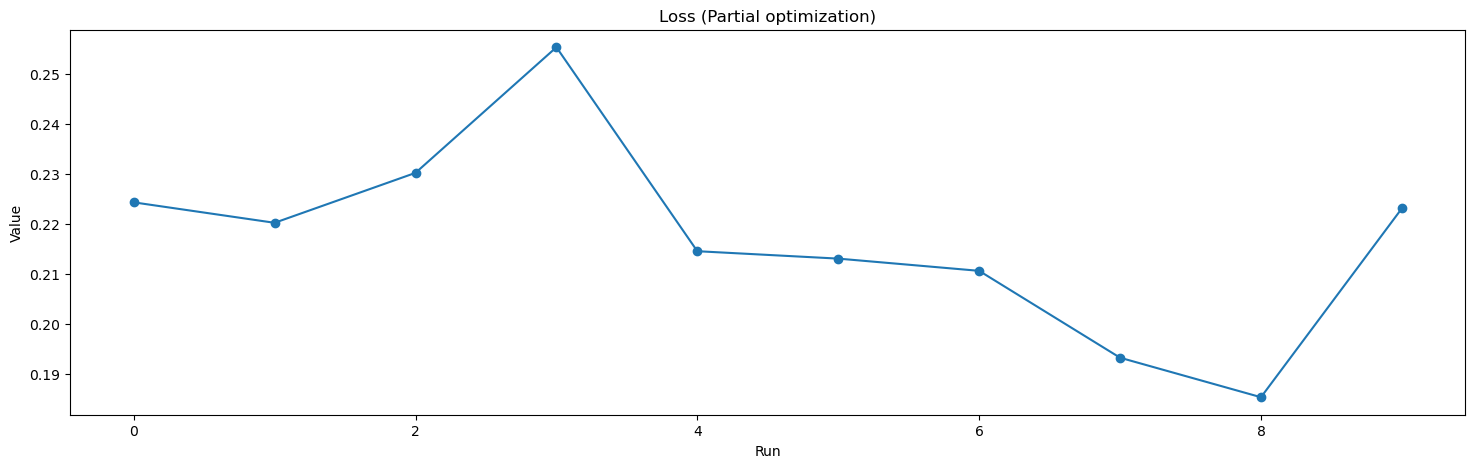

In [13]:
print("Best loss:", best_loss)

plt.figure(figsize=(18, 5))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Run")
plt.ylabel("Value")
plt.title("Loss (Partial optimization)")
plt.show()